## Neural Network Notebook for Object Classification with SDSS DR18

Within this notebook, we classify objects within SDSS DR18 using a neural network (NN). From this we can compare to the non-neural (non-NN) approach we took in the previous notebook, seeing where the two differ.

## Importing the libraries and reading the data ##

Once more, we import and install all the libraries necessary for our code - including those from pytorch and scikit-learn to build our NN. We use pytorch to generate our NN as it allows us to gain further insight into the model we develop below.

In [1]:
import kagglehub #used to get the data from kaggle.com
from kagglehub import KaggleDatasetAdapter #used to fetch the specific dataset from kaggle
import pandas as pd #used for viewing and manipulating the data
import matplotlib.pyplot as plt #used for data visulisation

import torch
import torch.nn as nn #used to create neural network
import torch.optim as optim #used to optimise neural network

from torch.utils.data import DataLoader, TensorDataset #import DataLoader and TensorDataset from pytorch
from sklearn.model_selection import train_test_split as skl_tts #imports train_test_split as skl_tts from sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler #imports LabelEncoder and StandardScaler from sklearn
from sklearn.metrics import classification_report as skl_cr #imports classification_report as skl_cr from sklearn
import seaborn as sns #imports seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #imports confusion_matrix and ConfusionMatrixDisplay from sklearn

import sys, os #imports sys and os, allows for modifying the path to get functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) #changes the path to include the py folder and its contents (parent folder)

from functions import * #calls all functions from functions.py

## Calling the data

As before, we load the dataset from the dataGrabber function which takes the data from its source and inputs it into our notebook for use.

In [2]:
data = dataGrabber() #reads in data from dataGrabber function

Now again, we look at the first five rows of the data.

In [3]:
pd.set_option('display.max_columns', None)
data.head()

,objid,specobjid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,plate,mjd,fiberid,petroRad_u,petroRad_g,petroRad_i,petroRad_r,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_i,petroFlux_r,petroFlux_z,petroR50_u,petroR50_g,petroR50_i,petroR50_r,petroR50_z,psfMag_u,psfMag_r,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,1.240000e+18,3.240000e+17,184.950869,0.733068,18.87062,17.59612,17.11245,16.83899,16.70908,756,301,5,462,288,52000,456,7.282402,7.004576,6.855976,7.112749,6.930960,30.66393,95.11749,181.718400,146.991600,207.027300,3.832911,3.659077,3.486617,3.621753,3.606744,21.11891,19.50324,19.96352,19.25145,19.05230,0.479021,0.518483,0.520474,0.508502,0.488969,0.041691,GALAXY
1,1.240000e+18,3.250000e+17,185.729201,0.679704,19.59560,19.92153,20.34448,20.66213,20.59599,756,301,5,467,289,51990,322,1.335305,1.321027,1.167182,1.266144,0.966431,14.55308,10.33474,4.623398,7.371214,4.824737,0.653159,0.659008,0.536881,0.650679,0.538456,19.58945,20.34491,19.92417,20.65535,20.57387,0.573926,0.531728,0.403072,0.999874,0.189495,-0.000814,STAR
2,1.240000e+18,3.240000e+17,185.687690,0.823480,19.26421,17.87891,17.09593,16.65159,16.35329,756,301,5,467,288,52000,614,3.874802,3.952013,4.007457,4.057646,3.818449,19.31011,72.75911,220.896700,148.093400,278.021100,1.898399,1.993737,1.944997,1.968584,1.863368,20.82290,18.54832,19.33645,18.16669,17.78844,0.701666,0.743386,0.770897,0.778642,0.736771,0.113069,GALAXY
3,1.240000e+18,2.880000e+18,185.677904,0.768362,19.49739,17.96166,17.41269,17.20545,17.11567,756,301,5,467,2558,54140,414,1.251496,1.325716,1.176959,1.281164,1.199375,15.33828,62.74539,125.370700,104.867200,134.623300,0.633329,0.679328,0.611904,0.657945,0.622971,19.49706,17.42272,17.96176,17.21564,17.12367,0.999818,0.787760,0.745611,0.399718,0.986137,0.000087,STAR
4,1.240000e+18,2.880000e+18,185.814763,0.776940,18.31519,16.83033,16.26352,16.06320,15.97527,756,301,5,467,2558,54140,403,1.365736,1.336521,1.161740,1.266766,1.239413,45.91689,178.20720,359.093500,300.775600,388.320300,0.677250,0.680561,0.613476,0.655520,0.640669,18.33505,16.28580,16.85104,16.08275,15.98694,0.999795,0.834450,0.723526,0.712259,0.527055,0.000018,STAR


Then we plot our the distribution of our classes within the dataset.

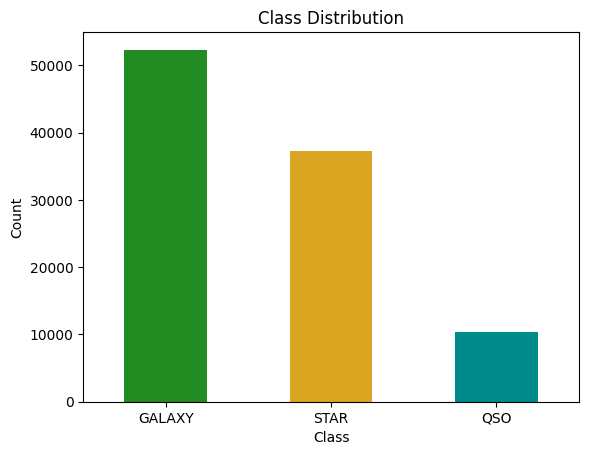

In [4]:
data['class'].value_counts().plot(kind='bar', color = ['forestgreen', 'goldenrod', 'darkcyan'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation = 0)
plt.show()

## Preprocessing our data

Now we have to prepare our data for the NN. This makes sure the data is within a suitable format for being trained by the NN correctly, taking the following steps: 
- selecting our relevant targets
- encoding our target labels
- normalising the data's features
- undergoing train test split on the data
- converting the data to tensors to be put into the NN.

In [10]:
features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.2 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

xTrainTensor = torch.tensor(xTrain, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrain, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

## Defining and utilising our Neural Network

With the preprocessing of our data, we can begin to build our NN to perform analysis.

In [ ]:
class NeuralNetworkClassifierExample(nn.Module): #defines the neural network being used
    def __init__(self):
        super(NeuralNetworkClassifierExample, self).__init__() #used to initialise internal components
        self.fc1 = nn.Linear(5, 64) #creates the first layer, with 5 input features and 64 output neurons
        self.fc2 = nn.Linear(64, 32) #creates second layer, with 64 inputs and 32 outputs
        self.fc3 = nn.Linear(32, 3) #creates third layer, with 32 inputs and 3 outputs
        self.relu = nn.ReLU() #defines the ReLu activation function, this replaces negative values with zero
        self.dropout = nn.Dropout(0.3) #defines the dropout layer, with a probability of setting 30% of neurons to 0
    
    def forward(self, z):
        z = self.relu(self.fc1(z)) #passes an input z through the first layer and applies relu
        z = self.dropout(z) #applies droputout to the output
        z = self.relu(self.fc2(z)) #passes data through second layer and applies relu
        z = self.fc3(z) #passes data through the final layer
        return z

This complicated looking function defines a custom neural network class, called `NeuralNetworkClassifierExample` here, but `NeuralNetworkClassifier` when being used in this notebook - this is from the nn.Module module of pytorch, the base class for all of pytorch's neural networks.

Firstly, `__init__` initialises the networks layers and components, then `forward` defines how the data passes through our NN when data is inputted. Overall, the architecture of our NN is as follows:

- Input layer: takes the 5 features defined as its input
- First layer: connected using 64 neurons and ReLU activation
- Dropout: randomly drops out neurons to regularise the model
- Second layer: connected using 32 neurons and ReLU activation
- Output layer: connected with 3 neurons, representing each of our classes

Using our now defined NN, we are able to initialise it, as seen below - with this we can now train our model with the dataset!

In [ ]:
model = NeuralNetworkClassifier() #calls NeuralNetworkClassifier function to define the model, storing it as a variable model

## Training and Evaluation of the model:

Using the defined and initialised NN, we are able to move to training our model with our dataset. From this we can evaluate the performance of the model, looking at the loss per epoch, then discussing the classification report and creating a confusion matrix to display how our model works.

We call the function `modelTraining` to train the model, with inputs as follows:
- `trainLoader`, this is the data loader which contains the labels and training data
- `criteria`, this is the loss function we use to calculate the error of the model
- `optimiser`, this is the optimisation algorithm used which updates the weighting of the model
- `epochs`, these are the number of training cycles used by our model - a value we set to 25

Below we call this function, which returns the lossHistory which we can output along with the epochs, seen below.

The learning rate has been set to 0.001 which ensures we don't take too long to train our data, as well as preventing overshooting the optimal solution.

In [ ]:
criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001) #lr = learning rate, which determines the size of the steps used by the optimiser

epochs = 25
lossHistory = modelTraining(model, trainLoader, criteria, optimiser, epochs)

Epoch 1/25, loss = 0.618
Epoch 2/25, loss = 0.483
Epoch 3/25, loss = 0.446
Epoch 4/25, loss = 0.402
Epoch 5/25, loss = 0.379
Epoch 6/25, loss = 0.326
Epoch 7/25, loss = 0.301
Epoch 8/25, loss = 0.276
Epoch 9/25, loss = 0.257
Epoch 10/25, loss = 0.237
Epoch 11/25, loss = 0.237
Epoch 12/25, loss = 0.211
Epoch 13/25, loss = 0.201
Epoch 14/25, loss = 0.190
Epoch 15/25, loss = 0.187
Epoch 16/25, loss = 0.177
Epoch 17/25, loss = 0.174
Epoch 18/25, loss = 0.172
Epoch 19/25, loss = 0.166
Epoch 20/25, loss = 0.165
Epoch 21/25, loss = 0.162
Epoch 22/25, loss = 0.163
Epoch 23/25, loss = 0.161
Epoch 24/25, loss = 0.160
Epoch 25/25, loss = 0.159


We can now look at how the training loss is affected by successive epochs, with a trend towards a loss of around 17%.

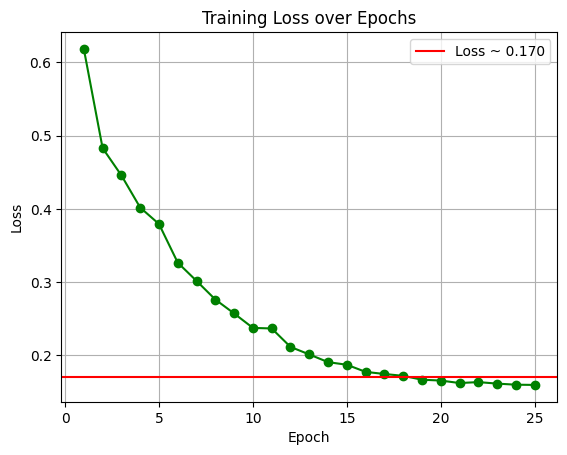

In [8]:
plt.plot(range(1, len(lossHistory) + 1), lossHistory, marker = 'o', color = 'g')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axhline(y = 0.170, xmin = 0, xmax = epochs, linestyle= '-', color = 'r', label = "Loss ~ 0.170")
plt.legend()
plt.grid()
plt.show()

With our model trained, we are able to evaluate its performance, printing out its classification report and a confusion matrix for the model to show how the model works.

Accuracy Score: 0.96
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.96     10428
         QSO       0.92      0.92      0.92      2068
        STAR       0.95      0.96      0.96      7504

    accuracy                           0.96     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000
 



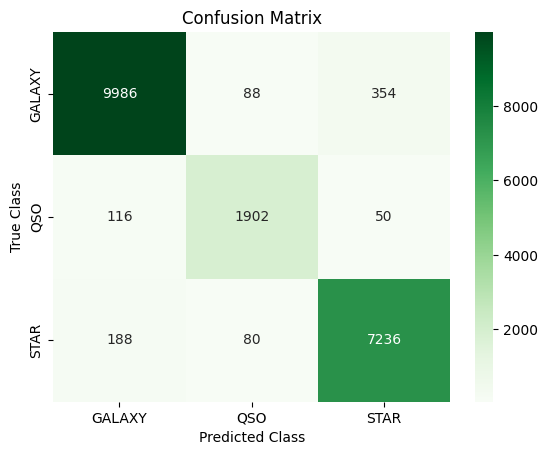

In [9]:
modelEvaluationNN(model, testLoader, labelEncoder)

## Conclusions of our model and how it compares to the non-neural approach

Now lets conclude our notebook by taking a look at how this approach (NN) compares to a decision tree (non-NN) from the notebook before.

In terms of accuracy, the decision tree (non-NN) had a fairly good accuracy of 71.7%, this is without any further optimisations of the model and without the inclusion of the redshift (a dominant feature which improves accuracy greatly) so is a respectable result. On the other hand, as seen above, the NN has a much more accurate result, with a 96% accuracy seen in the classification report. This matches the overall performance of our NN, which outperforms the non-NN in every metric, as seen below:

- Precision: **non-NN**; `0.76, 0.77 and 0.64` for a Galaxy, Quasar and Star respectively, with the star being the least accurate - compared to our **NN**; `0.97, 0.92 and 0.95` respectively for our NN approach, this is significantly more accurate for all classes, with the quasar classification being least accuarate
- Recall: **non-NN**; `0.77, 0.81 and 0.61` for the subsequent categories, whereas **NN**; `0.96, 0.92 and 0.96` for the three - this means on average the NN was able to more accurately determine the correct values with its approach, as well as having less of a range in recall (0.2 for non-NN, 0.04 for NN)
- F1-score: **non-NN**; `0.76, 0.79, 0.63` for the categories, **NN**; `0.96, 0.92 and 0.96` for the three, again showing the NN has a tighter range, meaning it performed better across all classifications rather than those that appeared the most frequently. Given the frequency of Galaxies and Stars in the dataset compared to Quasars, this parameter is an important one.

To conclude, it's easy to see that using a NN for a dataset this large is likely to give a more accurate modelling outcome than a non-NN, however given time constraints a non-NN may be the prefered approach due to its simplicity and interpretability, with the cost of accuracy. To further improve this NN, we could use other optimisation algorithms, utilise different network architectures, or modify the learning and dropout rates.